# Comparison between DFT and W90 bandstructures

In [1]:
# numerical module
import numpy as np

#setup plotting 
import matplotlib.pyplot as plt
plt.style.use('sci.mplstyle')

In [2]:
def read_band(fname, EFermi):
    bandData = np.loadtxt(fname)
    EF = EFermi
    kDist = np.unique(bandData[:, 0])
    numBand = len(bandData[bandData[:, 0] == kDist[1]])
    Bands = (np.reshape(bandData[:, 1], (-1, len(kDist))).T) - EF
    return kDist, Bands

In [3]:
# Fermi level
EF = 0.7694      # [eV]

# Band structure from the output of Wannier90
ks_w90, en_w90 = read_band('mos2_band.dat', EF)

# Band structrue from the output of Quantum ESPRESSO
ks_dft, en_dft = read_band('mos2.bands.gnu', EF)
# Unit of k points from DFT (2*pi/a)
k2 = 2*np.pi/3.19000
# Convert the unit of ks_dft to 1/Angstrom
ks_k2 = np.asarray(ks_dft)*k2

# High-symmetry labels
kLabel = (r'$\Gamma$', r'M', r'K', r'$\Gamma$')

# High-symmetry k-point positions [1/Å]
kNode  = [0.0000, 1.13707, 1.79354, 3.10650]

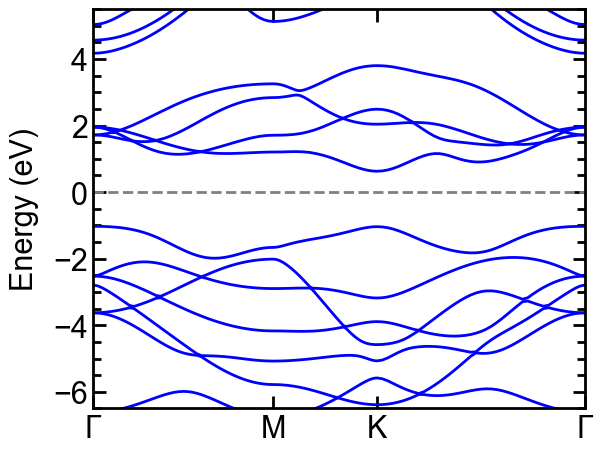

In [5]:
fig = plt.figure()

for i in range(en_dft.shape[1]):
    plt.plot(ks_k2, en_dft[:, i], color='blue', label='DFT')
    
#for i in range(en_w90.shape[1]):
#    plt.plot(ks_w90, en_w90[:, i], color='red', ls = 'none', marker='o', 
#         markersize=2, markevery=2, markerfacecolor='none', label='W90')

plt.axhline(0.0, color='gray', ls='--')
# X-Axis
plt.xlabel('')
plt.xlim(kNode[0], kNode[-1])
# Add labels for high-symmetry points
plt.xticks(kNode, kLabel)
# Y-Axis
plt.ylabel('Energy (eV)')
plt.ylim(-6.5, 5.5)

# Hide x-axis minor ticks
plt.tick_params(axis='x', which='minor', bottom=False, top=False)

plt.tight_layout()
fig.savefig('./band_dft_w90.png', dpi=600)
plt.show()

# Construct tight-binding model from `wannier90_hr.dat`

## Construct model

In [5]:
from pythtb import * # import TB model class

# read output from Wannier90 that should be in folder named "example_a"
# see instructions above for how to obtain the example output from 
# Wannier90

MoS2 = w90(r'\\wsl.localhost\Ubuntu-20.04\home\duytung1704\Wannier_OTM\14_4_W90andDFT', 'mos2')

# get tight-binding model without hopping terms above 0.01 eV and set Fermi level 
my_model = MoS2.model(zero_energy=EF,min_hopping_norm=0.01)
my_model.display()

---------------------------------------
report of tight-binding model
---------------------------------------
k-space dimension           = 3
r-space dimension           = 3
number of spin components   = 1
periodic directions         = [0, 1, 2]
number of orbitals          = 11
number of electronic states = 11
lattice vectors:
 #  0  ===>  [  3.1903 ,     0.0 ,     0.0 ]
 #  1  ===>  [ -1.5952 ,  2.7629 ,     0.0 ]
 #  2  ===>  [     0.0 ,     0.0 , 17.4395 ]
positions of orbitals:
 #  0  ===>  [     0.0 ,    -0.0 ,     0.0 ]
 #  1  ===>  [  0.0014 ,  0.0028 ,     0.0 ]
 #  2  ===>  [ -0.0014 , -0.0028 ,     0.0 ]
 #  3  ===>  [   -0.02 , -0.0399 ,     0.0 ]
 #  4  ===>  [    0.02 ,  0.0399 ,     0.0 ]
 #  5  ===>  [  0.3333 ,  0.6667 ,  0.1083 ]
 #  6  ===>  [  0.3402 ,  0.6804 ,  0.0858 ]
 #  7  ===>  [  0.3264 ,  0.6529 ,  0.0858 ]
 #  8  ===>  [  0.3333 ,  0.6667 , -0.1083 ]
 #  9  ===>  [  0.3402 ,  0.6804 , -0.0858 ]
 # 10  ===>  [  0.3264 ,  0.6529 , -0.0858 ]
site energies:
 # 

## Bandstructure

In [6]:
# ===== PATH for MoS₂ monolayer =====
path_mono = [
    [0.00000, 0.00000, 0.00000],   # Γ
    [0.50000, 0.00000, 0.00000],   # M
    [0.33333, 0.33333, 0.00000],   # K
    [0.00000, 0.00000, 0.00000]    # Γ
]

k_label = (r'$\Gamma$', r'M', r'K', r'$\Gamma$')

# call k_path for 1D bandstructure interpolation
(k_vec, k_dist, k_node) = my_model.k_path(path_mono, 201)

# calculate bands along this path
evals = my_model.solve_all(k_vec)


----- k_path report begin ----------
real-space lattice vectors
 [[ 3.19032  0.       0.     ]
 [-1.59516  2.76289  0.     ]
 [ 0.       0.      17.4395 ]]
k-space metric tensor
 [[0.131   0.0655  0.     ]
 [0.0655  0.131   0.     ]
 [0.      0.      0.00329]]
internal coordinates of nodes
 [[0.      0.      0.     ]
 [0.5     0.      0.     ]
 [0.33333 0.33333 0.     ]
 [0.      0.      0.     ]]
reciprocal-space lattice vectors
 [[0.31345 0.18097 0.     ]
 [0.      0.36194 0.     ]
 [0.      0.      0.05734]]
cartesian coordinates of nodes
 [[0.      0.      0.     ]
 [0.15672 0.09048 0.     ]
 [0.10448 0.18097 0.     ]
 [0.      0.      0.     ]]
list of segments:
  length = 0.18097  from  [0. 0. 0.]  to  [0.5 0.  0. ]
  length = 0.10448  from  [0.5 0.  0. ]  to  [0.33333 0.33333 0.     ]
  length = 0.20896  from  [0.33333 0.33333 0.     ]  to  [0. 0. 0.]
node distance list: [0.      0.18097 0.28545 0.49442]
node index list:    [  0  73 115 200]
----- k_path report end ------------


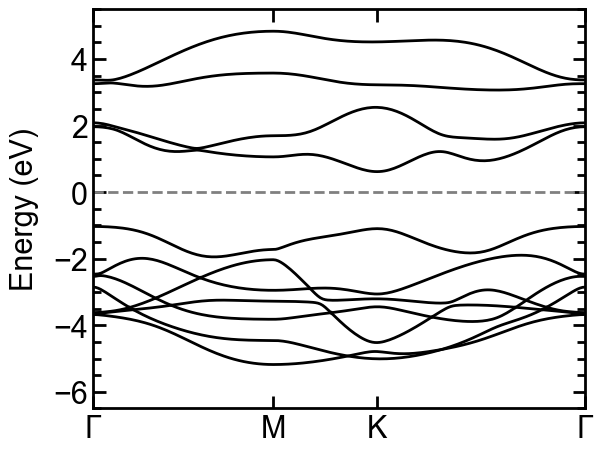

In [7]:
# plotting the tight-binding model
fig = plt.figure()
for i in range(evals.shape[0]):
    plt.plot(k_dist, evals[i], color='black')

plt.axhline(0.0, color='gray', ls='--')
# X-axis
plt.xlabel('')
plt.xlim(k_dist[0],k_dist[-1])
plt.xticks(k_node, k_label)
# Y-axis
plt.ylabel('Energy (eV)')
plt.ylim(-6.5, 5.5)
# Hide x-axis minor ticks
plt.tick_params(axis='x', which='minor', bottom=False, top=False)

plt.tight_layout()
fig.savefig('./band_TB.png', dpi=600)
plt.show()

## Edge State

In [8]:
#Cut the slab in the x-direction
slab_model = my_model.cut_piece(20, 0, glue_edgs=False)

# compute the band structure in the entire band
path_slab = [
[0.5,  0.0],
[0.0,  0.0],
[0.5,  0.0]
]

# labels of the nodes
k_label = (r'$\overline{X}$', r'$\overline{\Gamma}$', r'$\overline{X}$')

# call function k_path to construct the actual path
(k_vec_slab, k_dist_slab ,k_node_slab) = slab_model.k_path(path_slab,201)

# calculate the model
evals_slab = slab_model.solve_all(k_vec_slab)

----- k_path report begin ----------
real-space lattice vectors
 [[-1.59516  2.76289  0.     ]
 [ 0.       0.      17.4395 ]]
k-space metric tensor
 [[0.09825 0.     ]
 [0.      0.00329]]
internal coordinates of nodes
 [[0.5 0. ]
 [0.  0. ]
 [0.5 0. ]]
list of segments:
  length = 0.15672  from  [0.5 0. ]  to  [0. 0.]
  length = 0.15672  from  [0. 0.]  to  [0.5 0. ]
node distance list: [0.      0.15672 0.31345]
node index list:    [  0 100 200]
----- k_path report end ------------



c:\Users\PC\luan_an\newbie\.venv\Lib\site-packages\pythtb.py:3688: SyntaxWarning: invalid escape sequence '\_'
  """


KeyboardInterrupt: 

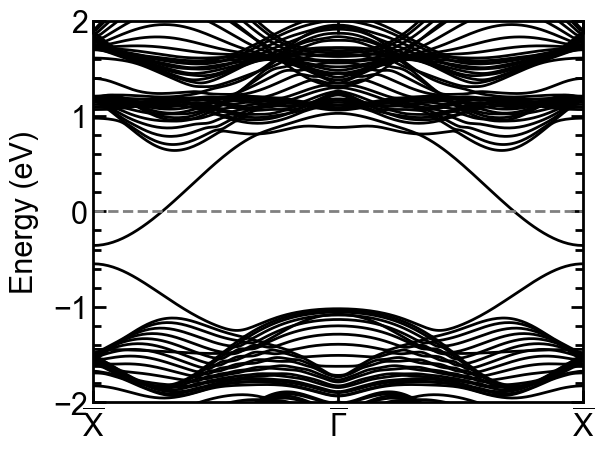

In [ ]:
# plotting the edge states
fig = plt.figure()
for i in range(evals_slab.shape[0]):
    plt.plot(k_dist_slab, evals_slab[i], color='black')

plt.axhline(0.0, color='gray', ls='--')
# X-axis
plt.xlabel('')
plt.xlim(k_dist_slab[0], k_dist_slab[-1])
plt.xticks(k_node_slab, k_label)
# Y-axis
plt.ylabel('Energy (eV)')
plt.ylim(-2, 2)
# Hide x-axis minor ticks
plt.tick_params(axis='x', which='minor', bottom=False, top=False)

plt.tight_layout()
fig.savefig('./edge_state.png', dpi=600)
plt.show()